<a href="https://colab.research.google.com/github/daawonn/dl_project/blob/master/2_%EA%B0%84%EB%8B%A8%ED%95%9C_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B0%8F_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%98%EC%9A%94_%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 연구목표

- BMI 지수 = (몸무게/키)*키
- BMI를 이용하여 비만도를 측정한다
- 알고리즘 SVM을 이용하여 BMI를 학습, 비만도 판정
- 데이터
  - 3_bmi.csv
  - 업로드 하여 사용

# 데이터 획득
  - 개발환경이 colab으로 변경되서 로컬파일을 업로드하여 사용해야 될것 같다.

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 3_bmi.csv to 3_bmi (1).csv
User uploaded file "3_bmi.csv" with length 264371 bytes


In [0]:
import numpy as np
import pandas as pd

In [0]:
df = pd.read_csv('/content/3_bmi.csv')
df.head(2)

,height,weight,label
0,178,69,normal
1,190,62,thin


# 데이터 준비
  - 품질 향상

In [0]:
# 데이터의 크기, 컬럼(피처의 종류), 레이블(종속변수)의 종류
df.shape, df.columns, df['label'].unique()

((20000, 3),
 Index(['height', 'weight', 'label'], dtype='object'),
 array(['normal', 'thin', 'fat'], dtype=object))

In [0]:
df.dtypes

height     int64
weight     int64
label     object
dtype: object

In [0]:
df['height'].max(), df['height'].min(), df['weight'].max(), df['weight'].min()

(200, 120, 80, 35)

In [0]:
# 데이터 정규화 -> 무게, 키의 최대치를 기준으로 처리하시오
# 처리된 값을 다시 해당 컬럼에 대입한다
df['height'] = df['height'] / df['height'].max()
df['weight'] = df['weight'] / df['weight'].max()
df.head(2)

,height,weight,label
0,0.89,0.8625,normal
1,0.95,0.7750,thin


In [0]:
# 레이블을 종속변수인데 분류를 백터화 해서 처리
# 케이스가 총 3개 -> 0 0 1, 0 1 0, 1 0 0
# thin   -> [ 1,0,0 ]
# normal -> [ 0,1,0 ]
# fat    -> [ 0,0,1 ] 값이 변경되도록 처리하시오
matchingTable = {
    'thin'  :np.array([1,0,0]),
    'normal':np.array([0,1,0]),
    'fat'   :np.array([0,0,1])
}
matchingTable

{'fat': array([0, 0, 1]), 'normal': array([0, 1, 0]), 'thin': array([1, 0, 0])}

In [0]:
df['label'] = df['label'].apply( lambda x: matchingTable[x] )
df.head(2)

,height,weight,label
0,0.89,0.8625,"[0, 1, 0]"
1,0.95,0.7750,"[1, 0, 0]"


In [0]:
# 데이터를 훈련용, 테스트용으로 분류한다
from sklearn.model_selection import train_test_split

In [0]:
# 비율 75:25, 난수 0으로 고정하려 분류하시오
# X_..  , y_... 변수명
#X_train, X_test, y_train, y_test = train_test_split(독립변수:DF, 종속변수:Se, 비율, 난수)
# df[ df.columns[:2] ] => df[ ['',''] ] => df.iloc[ : , :2 ]
X_train, X_test, y_train, y_test = train_test_split(df[ df.columns[:2] ], 
                                                    df['label'], 
                                                    test_size=0.25 , 
                                                    random_state=0)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15000, 2), (5000, 2), (15000,), (5000,))

# 데이터 분석
- 생략

# 머신러닝 모델링(딥러닝, 텐서플로우 사용)

- 각각의 출력값에 대해서, 가중치를 곱하고 합한후, 바이어스(편향, 조정한값)를 더해서 softmax라는 함수(판단보류)로 적용한것(간단한 퍼셉트론을 표현)
- 해당 이론을 수식으로 정리하여 함수로 표현
 [ 그림 sm0, sm1, sm2, sm3 참조 ]
- 간단하게 표현
  - y = softmax( Wx + b )
- 해당 수식을 데이터 플로우 그래프로 표현




## 데이터 플로우 그래프 준비

In [0]:
from IPython.display import Image
# 소프트맥스 함수 표현
# 활성화 함수중에 하나로, 
# 입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화하며 출력 값들의 총합은 
# 항상 1이 되는 특성을 가진 함수
Image('sm0.png', width=300)

In [0]:
# 퍼셉트론을 구현한 그림1
Image('sm1.png', width=300)

In [0]:
# 그림1을 수식으로 표현한 그림2
Image('sm2.png', width=300)

In [0]:
# 그림2의 수식을 간결하게 표현
Image('sm3.png', width=300)

In [0]:
import tensorflow as tf
%tensorflow_version 1.x

In [0]:
# 텐서플로우로 이 수식을 처리하기 위해 구현
# 입력 x : 키, 몸무게
x = tf.placeholder( tf.float32, [None,2] )

In [0]:
# 가중치 => 변할수있다 => 변수
# shape 형태를 고려
# tf.zeros()를 사용하면 초기값을 0. 부여하여 전체 타입을 float32로 통일
W = tf.Variable( tf.zeros([2, 3]) ) 

In [0]:
# 편향, 바이어스 => 변수
b = tf.Variable( tf.zeros([3]) )

In [0]:
# y = softmax( Wx + b )
# 데이터 플로우 그래프 -> 계산식
# x는 matrix, 2차 행렬, [none, 2] 
# 행렬의 곱 (none, 2) * ( 2, 3 ) => (none, 3)
# 3은 결과(y의 총 케이스수:정답의 개수(정상, 마름, 비만))
# 바이어스(편향)값은 브로드 캐스팅에 의해서 행렬을 확장시켜 계산 처리 된다
y = tf.nn.softmax(tf.matmul(x,W) + b)

In [0]:
# 데이터 플로우 그래프이 핵심 => shape을 맞춰야 한다
'%s X %s + %s = %s' % (x.shape, W.shape, b.shape, y.shape)

'(?, 2) X (2, 3) + (3,) = (?, 3)'

## 학습에 필요한 데이터 플로우 그래프 추가

- 좋은 모델을 만들기 위한 장치
  - 기준점
    - 비용(cost), 손실(loss)등 값들이 원하는 값에서 얼마나 떨어져 있는가 이것을 판단의 지표로 본다
    - 이 값들을 줄이는 방향으로 전개된다
    - 이런 처리를 위해서 "크로스 엔트로피"와 같은 알고리즘을 적용
    - 정보 이론 분야의 정보 압축 알고리즘으로 고안되었고,
    - 실제로는 베팅, 머신러닝쪽에서 중요한 알고리즘,아이디어로 사용된다

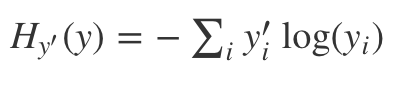

In [0]:
# 크로스 엔트로피 함수
Image('sm4.png', width=200)

In [0]:
# y_ : 정답 레이블
# y  : 예측 레이블 
# y_ : [1,0,0], [0,1,0], [0, 0, 1], .... => [None, 3]
y_ = tf.placeholder( tf.float32, [None, 3] )

In [0]:
# 크로스 엔트로피를 구성
cross_entropy = -tf.reduce_sum( y_ * tf.log(y) )

In [0]:
# 크로스 엔트로피가 최소화 되도록 작업을 진행시킨다
# 경사 하강법(Gradient descent algorithm)으로 수행
# 경사 하강법을 적용하면, 텐서플로우가 변수를 비용을 줄이는 방향으로 조금씩 이동시켜서 연산수행
# => 비용, 손실등을 최소가 되겠금, 오차율을 최소로 만들게끔 처리
# 하이퍼파라미터는 일단 0.01 적용
optimazer = tf.train.GradientDescentOptimizer(0.01)

In [0]:
# 훈련을 정의
# 최소화 하기 위해서 minimize() 사용
train = optimazer.minimize( cross_entropy )

In [0]:
# 정답률 예측 정의
# y  : 예측 레이블 
# y_ : 정답 레이블
# tf.argmax( y, 1) : 모델이 판단하기에 각 데이터별로 적합하다고 판단되는 레이블 값으로 취한다
predict = tf.equal( tf.argmax(y,1), tf.argmax(y_, 1) )

In [0]:
predict, train, optimazer, cross_entropy

(<tf.Tensor 'Equal:0' shape=(?,) dtype=bool>,
 <tf.Operation 'GradientDescent' type=NoOp>,
 <tf.Tensor 'Neg:0' shape=() dtype=float32>)

In [0]:
# 정확도 => 부동소수 변환하여 평균값을 획득
accuracy = tf.reduce_mean( tf.cast(predict, tf.float32) )

## 세션 가동 실행

- Session을 구해서 처리
- 데이터를 증가시키면서 반복 학습
  - 데이터를 양을 0-100, 0-200 이런 느낌으로 증가
  - 데이터를 0-100, 100-200, 횟수를 증가할것인가
    - 횟수를 증가, 새로운 데이터로 학습

In [0]:
type(X_train), X_train.shape[0] #데이터의 총개수

(pandas.core.frame.DataFrame, 15000)

In [0]:
# 모든 컬럼을 포함한 상태로 연속적인 인덱스를 기준으로 데이터를 추출
# df[ : ] 사용하면 간단하게 해결
X_train.head()[1:3], X_train.head().iloc[1:3, :]

(       height  weight
 17768   0.750  0.8375
 19492   0.675  0.4500,        height  weight
 17768   0.750  0.8375
 19492   0.675  0.4500)

In [0]:
tmps = X_train[0:100]
tmps.head(2)
# 훈련시 컬럼 순서를 재조정해야 한다면 활용, 테스트 데이터등 컬럼순서 검토
#tmps[ ['weight','height'] ].head(2)

,height,weight
16152,0.91,0.8125
17768,0.75,0.8375


In [0]:
y_train[0:100][:2]

16152    [0, 1, 0]
17768    [0, 0, 1]
Name: label, dtype: object

In [0]:
with tf.Session() as sess:
  # 1. 변수 초기화(조건 초기화)
  sess.run( tf.global_variables_initializer() )
  # 2. 훈련 데이터를 나눠서 훈련시 주입하기 위한 기준값 정의  
  # 2-1. 훈련 한번 수행시 데이터 크기
  TRAIN_TERM = 100  
  # 2-2. 몇번까지 훈련을 진행할 것인가 훈련 횟수 
  train_count = int(X_train.shape[0] / TRAIN_TERM)
  # 3. 학습 수행, 반복적으로
  for step in range(train_count): # step:(0~149)
    # 3-1. 훈련데이터에서 데이터를 순차적으로 추출
    # step:(0~149)*100=>0~14900
    offset = step*TRAIN_TERM
    datas  = X_train[ offset : offset + TRAIN_TERM]
    # 3-2. 학습
    # 학습 데이터 준비
    # 플레이스홀더 변수값을 채운다
    # datas : 컬럼 순서 주의(피처의 순서), 테스트 데이터의 피처 순서와 동일
    fd = { x:datas , y_:list(y_train[ offset : offset + TRAIN_TERM]) }
    # 훈련 데이터 주입 => feed_dict=
    # 학습 수행
    sess.run( train, feed_dict=fd )
    # 중간 확인 : 결론만 보지말고, 과정을 확인해서, 어던 변화가 있었는지를 점검
    # 10번째 마다 결과를확인하겠다, 0도 포함
    if step%10 == 0:
      # 크로스 엔트로피 값 획득 해라
      cross_en = sess.run( cross_entropy, feed_dict=fd )
      # 정확도 획득 해라
      # 정확도 => 한번도 접하지 못한 데이터를 넣어서 예측한값을 정답과 비교하여
      # 측정하는것이다 => 데이터 주입 : 테스트 데이터, 테스트 데이터의 답
      acc      = sess.run( accuracy, feed_dict={x:X_test, y_:list(y_test)} )
      # 로그 출력
      print( 'step=%s, cro=%s, acc=%s' % (step, cross_en, acc) )
    pass # end for
  # step 149번 최종 정확도
  acc      = sess.run( accuracy, feed_dict={x:X_test, y_:list(y_test)} )
  print( '마지막회수의 정확도', acc )
  pass # end with

step=0, cro=106.28909, acc=0.3788
step=10, cro=101.96707, acc=0.534
step=20, cro=100.24037, acc=0.6822
step=30, cro=94.6657, acc=0.6798
step=40, cro=93.02731, acc=0.6716
step=50, cro=91.353935, acc=0.6862
step=60, cro=81.40004, acc=0.6728
step=70, cro=84.915985, acc=0.7228
step=80, cro=84.13021, acc=0.695
step=90, cro=81.22965, acc=0.6832
step=100, cro=78.59924, acc=0.7426
step=110, cro=78.421616, acc=0.6772
step=120, cro=75.88559, acc=0.7066
step=130, cro=77.74769, acc=0.6844
step=140, cro=68.8153, acc=0.6914
마지막회수의 정확도 0.7456


In [0]:
with tf.Session() as sess:
  # 1. 변수 초기화(조건 초기화)
  sess.run( tf.global_variables_initializer() )
  # 2. 훈련 데이터를 나눠서 훈련시 주입하기 위한 기준값 정의  
  # 2-1. 훈련 한번 수행시 데이터 크기
  TRAIN_TERM = 100  


  
  # 2-2. 몇번까지 훈련을 진행할 것인가 훈련 횟수 
  train_count = int(X_train.shape[0] / TRAIN_TERM)
  # 횟수를 4배 증가
  STEP_SEGMENT = 2*2*2*2  # 수치를 2, 4 등 넣어보니 증가는 하지만 증가치가 감속한다.
  # 2 -> 10% 증가, 4 -> 5% 증가, 8-> 2.5% 증가 ..등등
  # 실제로 적용해 보니 상승폭이 더 둔화되었다 => 93.4% 도달
  # 중복적으로 훈련된 데이터가 수치가 커질수록 많아져서 떨어지지 않았을까?  => 아이디어
  # 3. 학습 수행, 반복적으로
  for step in range(train_count*STEP_SEGMENT): # step:(0~149)
    # 3-1. 훈련데이터에서 데이터를 순차적으로 추출
    # step:(0~149)*100=>0~14900
    offset = int(step*TRAIN_TERM/STEP_SEGMENT)
    datas  = X_train[ offset : offset + TRAIN_TERM]
    # 3-2. 학습
    # 학습 데이터 준비
    # 플레이스홀더 변수값을 채운다
    # datas : 컬럼 순서 주의(피처의 순서), 테스트 데이터의 피처 순서와 동일
    fd = { x:datas , y_:list(y_train[ offset : offset + TRAIN_TERM]) }
    # 훈련 데이터 주입 => feed_dict=
    # 학습 수행
    sess.run( train, feed_dict=fd )
    # 중간 확인 : 결론만 보지말고, 과정을 확인해서, 어던 변화가 있었는지를 점검
    # 10번째 마다 결과를확인하겠다, 0도 포함
    if step%10 == 0:
      # 크로스 엔트로피 값 획득 해라
      cross_en = sess.run( cross_entropy, feed_dict=fd )
      # 정확도 획득 해라
      # 정확도 => 한번도 접하지 못한 데이터를 넣어서 예측한값을 정답과 비교하여
      # 측정하는것이다 => 데이터 주입 : 테스트 데이터, 테스트 데이터의 답
      acc      = sess.run( accuracy, feed_dict={x:X_test, y_:list(y_test)} )
      # 로그 출력
      print( 'step=%s, cro=%s, acc=%s' % (step, cross_en, acc) )
    pass # end for
  # step 149번 최종 정확도
  acc      = sess.run( accuracy, feed_dict={x:X_test, y_:list(y_test)} )
  print( '마지막회수의 정확도', acc )
  pass # end with

step=0, cro=106.28909, acc=0.3788
step=10, cro=101.6417, acc=0.3788
step=20, cro=95.83631, acc=0.46
step=30, cro=94.224106, acc=0.6388
step=40, cro=92.86491, acc=0.7148
step=50, cro=92.2722, acc=0.6984
step=60, cro=89.7535, acc=0.793
step=70, cro=84.31235, acc=0.5318
step=80, cro=81.48253, acc=0.805
step=90, cro=80.034706, acc=0.6806
step=100, cro=80.55241, acc=0.6814
step=110, cro=79.41415, acc=0.6986
step=120, cro=75.05969, acc=0.8148
step=130, cro=74.690384, acc=0.8082
step=140, cro=75.44251, acc=0.8008
step=150, cro=75.71866, acc=0.8212
step=160, cro=68.12229, acc=0.691
step=170, cro=62.88241, acc=0.6848
step=180, cro=68.56894, acc=0.6824
step=190, cro=63.02624, acc=0.6752
step=200, cro=68.01746, acc=0.7302
step=210, cro=67.419556, acc=0.7324
step=220, cro=64.86983, acc=0.7268
step=230, cro=64.678894, acc=0.7784
step=240, cro=65.125626, acc=0.8458
step=250, cro=67.98277, acc=0.8662
step=260, cro=66.837654, acc=0.7834
step=270, cro=60.797077, acc=0.715
step=280, cro=60.655125, acc=0

In [0]:
with tf.Session() as sess:
  sess.run( tf.global_variables_initializer() )
  TRAIN_TERM = 100  
  train_count = int(X_train.shape[0] / TRAIN_TERM)
  STEP_SEGMENT = 2*2*2*2 
  for step in range(train_count*STEP_SEGMENT):
    offset = int(step*TRAIN_TERM/STEP_SEGMENT)
    datas  = X_train[ offset : offset + TRAIN_TERM]
    fd = { x:datas , y_:list(y_train[ offset : offset + TRAIN_TERM]) }
    sess.run( train, feed_dict=fd )
    if step%STEP_SEGMENT == 0:
      cross_en = sess.run( cross_entropy, feed_dict=fd )
      acc      = sess.run( accuracy, feed_dict={x:X_test, y_:list(y_test)} )
      print( 'step=%s, cro=%s, acc=%s' % (step, cross_en, acc) )
    pass # end for
  acc      = sess.run( accuracy, feed_dict={x:X_test, y_:list(y_test)} )
  print( '마지막회수의 정확도', acc )
  pass # end with

step=0, cro=106.28909, acc=0.3788
step=16, cro=97.68382, acc=0.4046
step=32, cro=94.6158, acc=0.623
step=48, cro=91.69449, acc=0.7016
step=64, cro=87.549416, acc=0.719
step=80, cro=81.48253, acc=0.805
step=96, cro=81.0717, acc=0.661
step=112, cro=78.853745, acc=0.7536
step=128, cro=73.00946, acc=0.7486
step=144, cro=75.01828, acc=0.818
step=160, cro=68.12229, acc=0.691
step=176, cro=62.463814, acc=0.6828
step=192, cro=65.49155, acc=0.6866
step=208, cro=67.22739, acc=0.7402
step=224, cro=64.77496, acc=0.7442
step=240, cro=65.125626, acc=0.8458
step=256, cro=68.32594, acc=0.862
step=272, cro=62.622192, acc=0.7408
step=288, cro=53.81114, acc=0.7004
step=304, cro=59.383442, acc=0.775
step=320, cro=61.36272, acc=0.815
step=336, cro=60.890743, acc=0.8784
step=352, cro=59.502785, acc=0.8822
step=368, cro=60.583725, acc=0.8654
step=384, cro=54.07996, acc=0.8678
step=400, cro=55.819664, acc=0.8086
step=416, cro=57.83302, acc=0.8924
step=432, cro=55.281403, acc=0.8532
step=448, cro=52.920937, ac

# 텐서보드
- 목적
  - 텐서보드를 이용하여 그래프를 시각적으로 확인
  - 데이터의 플로우(흐름)을 볼 수 있다
- 방법
  - 로컬pc에서 수행하는 방법
  - colab에서 수행하는 방법
  - 데이터가 누적되기때문에 클리어후 처리하는게 정확하게 나온다  

In [0]:
# 총정리
# 1. 텐서 데이터 플로우 구현
x = tf.placeholder( tf.float32, [None,2] )
W = tf.Variable( tf.zeros([2, 3]) ) 
b = tf.Variable( tf.zeros([3]) )
y = tf.nn.softmax(tf.matmul(x,W) + b)
y_ = tf.placeholder( tf.float32, [None, 3] )
cross_entropy = -tf.reduce_sum( y_ * tf.log(y) )
optimazer = tf.train.GradientDescentOptimizer(0.01)
train = optimazer.minimize( cross_entropy )
predict = tf.equal( tf.argmax(y,1), tf.argmax(y_, 1) )
accuracy = tf.reduce_mean( tf.cast(predict, tf.float32) )


# 2. 텐서보드를 위해서 추가된 코드(코랩에서 사용하는 스타일)
from tensorboardcolab import *
import shutil, os
# 디렉토리 및 그 이하 파일가지 삭제, 에러나면 무시
shutil.rmtree('./Graph', ignore_errors=True)
# 디렉토리 생성
os.mkdir('./Graph')
# 기존의 tf에 만들어진 요소들을 초기화처리(에러 날수도 있음)
# tf.reset_default_graph()
# 텐서보드 객체 생성
tbc = TensorBoardColab()

# 3. 실행을 통한 학습, 예측 처리
with tf.Session() as sess:
  sess.run( tf.global_variables_initializer() )
  TRAIN_TERM = 100  
  train_count = int(X_train.shape[0] / TRAIN_TERM)
  STEP_SEGMENT = 2*2*2*2 
  for step in range(train_count*STEP_SEGMENT):
    offset = int(step*TRAIN_TERM/STEP_SEGMENT)
    datas  = X_train[ offset : offset + TRAIN_TERM]
    fd = { x:datas , y_:list(y_train[ offset : offset + TRAIN_TERM]) }
    sess.run( train, feed_dict=fd )
    if step%STEP_SEGMENT == 0:
      cross_en = sess.run( cross_entropy, feed_dict=fd )
      acc      = sess.run( accuracy, feed_dict={x:X_test, y_:list(y_test)} )
      #print( 'step=%s, cro=%s, acc=%s' % (step, cross_en, acc) )
    pass # end for
  acc      = sess.run( accuracy, feed_dict={x:X_test, y_:list(y_test)} )
  #print( '정확도', acc )
  # 코랩 텐서보드의 물리적위치에 그래프를 기록
  writer = tbc.get_writer()
  writer.add_graph( sess.graph )  # 그래프 추가
  writer.flush() # 강제로 전송

  pass # end with

# 4. 텐서보드를 닫는다
tbc.close()

Wait for 8 seconds...
TensorBoard link:
http://7b385084.ngrok.io
step=0, cro=106.28909, acc=0.3788
step=16, cro=97.68382, acc=0.4046
step=32, cro=94.6158, acc=0.623
step=48, cro=91.69449, acc=0.7016
step=64, cro=87.549416, acc=0.719
step=80, cro=81.48253, acc=0.805
step=96, cro=81.0717, acc=0.661
step=112, cro=78.853745, acc=0.7536
step=128, cro=73.00946, acc=0.7486
step=144, cro=75.01828, acc=0.818
step=160, cro=68.12229, acc=0.691
step=176, cro=62.463814, acc=0.6828
step=192, cro=65.49155, acc=0.6866
step=208, cro=67.22739, acc=0.7402
step=224, cro=64.77496, acc=0.7442
step=240, cro=65.125626, acc=0.8458
step=256, cro=68.32594, acc=0.862
step=272, cro=62.622192, acc=0.7408
step=288, cro=53.81114, acc=0.7004
step=304, cro=59.383442, acc=0.775
step=320, cro=61.36272, acc=0.815
step=336, cro=60.890743, acc=0.8784
step=352, cro=59.502785, acc=0.8822
step=368, cro=60.583725, acc=0.8654
step=384, cro=54.07996, acc=0.8678
step=400, cro=55.819664, acc=0.8086
step=416, cro=57.83302, acc=0.892

In [0]:
# 기존의 tf에 만들어진 요소들을 초기화처리(에러 날수도 있음)
tf.reset_default_graph()

# 텐서보드에 네임스페이스를 부여하기 위해 조정
x  = tf.placeholder( tf.float32, [None,2] )
y_ = tf.placeholder( tf.float32, [None, 3] ) # 정답

with tf.name_scope('interface') as scope:
  W = tf.Variable( tf.zeros([2, 3]) ) 
  b = tf.Variable( tf.zeros([3]) )
  with tf.name_scope('activation') as scope:
    y = tf.nn.softmax(tf.matmul(x,W) + b)                      # 간단한 입출력층 구성

with tf.name_scope('loss') as scope:
  cross_entropy = -tf.reduce_sum( y_ * tf.log(y) )             # 크로스엔트로피

with tf.name_scope('training') as scope:  
  optimazer = tf.train.GradientDescentOptimizer(0.01)          # 경사하강법
  train = optimazer.minimize( cross_entropy )                  # 훈련

with tf.name_scope('accuracy') as scope:
  predict = tf.equal( tf.argmax(y,1), tf.argmax(y_, 1) )       # 예측
  accuracy = tf.reduce_mean( tf.cast(predict, tf.float32) )    # 평가


# 텐서보드를 위해서 추가된 코드(코랩에서 사용하는 스타일)
from tensorboardcolab import *
import shutil, os
# 디렉토리 및 그 이하 파일가지 삭제, 에러나면 무시
shutil.rmtree('./Graph', ignore_errors=True)
# 디렉토리 생성
os.mkdir('./Graph')
# 텐서보드 객체 생성
tbc = TensorBoardColab()

# 실행을 통한 학습, 예측 처리
with tf.Session() as sess:
  sess.run( tf.global_variables_initializer() )
  TRAIN_TERM = 100  
  train_count = int(X_train.shape[0] / TRAIN_TERM)
  STEP_SEGMENT = 2*2*2*2 
  for step in range(train_count*STEP_SEGMENT):
    offset = int(step*TRAIN_TERM/STEP_SEGMENT)
    datas  = X_train[ offset : offset + TRAIN_TERM]
    fd = { x:datas , y_:list(y_train[ offset : offset + TRAIN_TERM]) }
    sess.run( train, feed_dict=fd )
    if step%STEP_SEGMENT == 0:
      cross_en = sess.run( cross_entropy, feed_dict=fd )
      acc      = sess.run( accuracy, feed_dict={x:X_test, y_:list(y_test)} )
      #print( 'step=%s, cro=%s, acc=%s' % (step, cross_en, acc) )
    pass # end for
  acc      = sess.run( accuracy, feed_dict={x:X_test, y_:list(y_test)} )
  #print( '정확도', acc )
  # 코랩 텐서보드의 물리적위치에 그래프를 기록
  writer = tbc.get_writer()
  writer.add_graph( sess.graph )  # 그래프 추가
  writer.flush() # 강제로 전송

  pass # end with

# 텐서보드를 닫는다
tbc.close()

Wait for 8 seconds...
TensorBoard link:
https://7b385084.ngrok.io


# 시스템 통합
- 산출물 없다 : skip